# Figures

## Dimensionality reduction plot of parameters fit to experimental data using FEM simulations

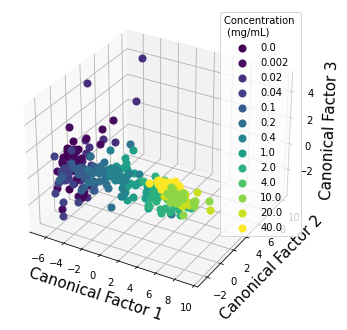

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from pingouin import multivariate_normality
import math
import scipy

# read 
df_full = pd.read_csv(r"../TrainingData/FEMFitParameters.csv",sep=',',header=0)
df_full = df_full.iloc[:,1:]
Concentration = df_full.iloc[:,0]
df_data = df_full.iloc[:,1:]
MultivariateNormal = pd.DataFrame([])

df_std = StandardScaler().fit_transform(df_data)

lda = LinearDiscriminantAnalysis(n_components=3, tol=1e-3, solver = 'svd')
LinearDiscriminants = lda.fit_transform(df_std, Concentration.to_numpy(dtype='str'))

pca = PCA(n_components=3)
PrincipalComponents = pca.fit_transform(df_std)

df_reducedDimensions = pd.DataFrame(data = PrincipalComponents
              , columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])

df_reducedDimensions = pd.DataFrame(data = LinearDiscriminants
              , columns = ['Canonical Factor 1', 'Canonical Factor 2', 'Canonical Factor 3'])

df_labelledprincipal = pd.concat([Concentration, df_reducedDimensions], axis = 1)

fig = plt.figure(figsize = (5.5,5.5))
ax = fig.add_subplot(111, projection = '3d') 
ax.set_xlabel(df_reducedDimensions.columns[0], fontsize = 15)
ax.set_ylabel(df_reducedDimensions.columns[1], fontsize = 15)
ax.set_zlabel(df_reducedDimensions.columns[2], fontsize = 15)

UniqueConcentrations = np.sort(df_labelledprincipal.Concentration.unique())

for concentration in UniqueConcentrations:
    indicesToKeep = df_labelledprincipal['Concentration'] == concentration
#     print(scipy.stats.normaltest(df_data.loc[indicesToKeep,['0','1','2','3','4','5','Max','lr']]))
#     print(multivariate_normality(df_data.loc[indicesToKeep,['0','1','2','3','4','5','Max','lr']], alpha=.05))
    Mean = pd.DataFrame(np.array(np.mean(df_data.loc[indicesToKeep,:],axis=0))).T
    Cov = pd.DataFrame(np.cov(df_data.loc[indicesToKeep,:],rowvar=False))
    MeanCovConc = pd.concat([Mean,Cov], axis=0, ignore_index=False)
    MeanCovConc.columns = list(df_data.columns)
    MeanCovConc["Concentration"] = [concentration]*len(MeanCovConc.index)
    MultivariateNormal = pd.concat([MultivariateNormal,MeanCovConc], axis=0)
    colour = round(255*(math.log(float(concentration)+1e-2) - math.log(1e-2))/(math.log(40) - math.log(1e-2)))
    ax.scatter(df_labelledprincipal.loc[indicesToKeep, df_reducedDimensions.columns[0]]
               , df_labelledprincipal.loc[indicesToKeep, df_reducedDimensions.columns[1]]
               , df_labelledprincipal.loc[indicesToKeep, df_reducedDimensions.columns[2]]
               , color = pylab.cm.viridis(colour)
               , s = 50
               , depthshade=False)
    

ax.legend(UniqueConcentrations,title="Concentration \n (mg/mL)")
plt.show()

MultivariateNormal.to_csv("../TrainingData/FEMFitParametersDistribution.csv")

## test for multivariate normality
# print(multivariate_normality(df_data, alpha=.05))
# print(scipy.stats.normaltest(df_data))
# print(np.cov(df_std,rowvar=False))


## Estimating Distribution of Parameters

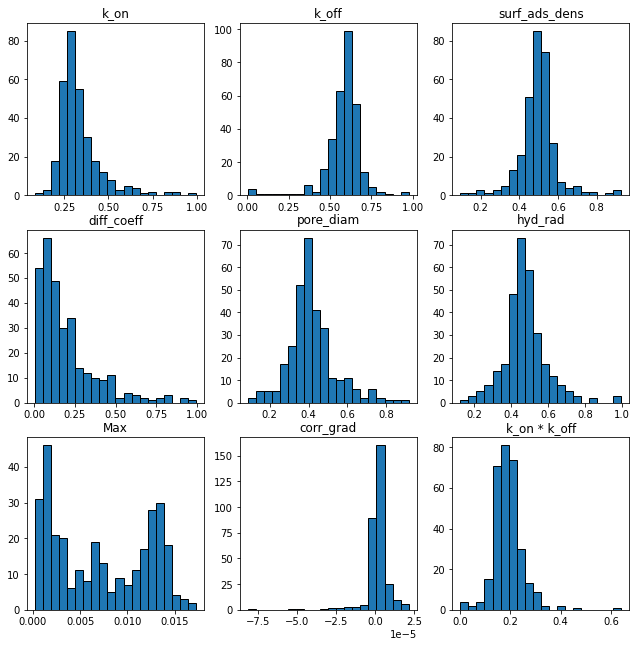

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from pingouin import multivariate_normality
import math
import scipy

subplotRows = 3
subplotColumns = 3

# read 
df_full = pd.read_csv(r"../TrainingData/FEMFitParameters.csv",sep=',',header=0)
df_full = df_full.iloc[:,1:]
Concentrations = df_full.iloc[:,0]
df_data = df_full.iloc[:,1:]
df_data["k_on * k_off"] = df_data.k_on*df_data.k_off

# #define format for subplots
fig, ax = plt.subplots(subplotColumns, subplotRows, figsize=(subplotColumns*3.6,subplotRows*3.6))
i=0
for column in range(subplotColumns):
    for row in range(subplotRows):
        ax[column,row].hist(df_data.iloc[:,i], edgecolor='k', density=False, bins=20)
        ax[column,row].set_title(df_data.iloc[:,i].name)
        i+=1

## Semilog plot of average equilibrium response vs concentration

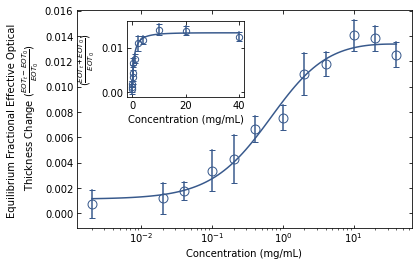

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import pylab

#
SequenceLength = 250
markerSize = 80
insetMarkerSize = 40
viridisColour = 70

df = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)

time = df.iloc[0,1:]/3600
dftrain = df.iloc[1:,:]

concentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
fig, ax = plt.subplots()
Means = []
Stdevs = []
for concentration in concentrations:
    Mean = np.mean(dftrain.loc[concentration,SequenceLength])
    Stdev = np.std(dftrain.loc[concentration,SequenceLength],ddof=1)
    Means.append(Mean)
    Stdevs.append(Stdev)
    Concentration = float(concentration)
    plt.scatter(Concentration,Mean, facecolor=(0,0,0,0), edgecolor=pylab.cm.viridis(viridisColour), marker='o', s=markerSize)
    plt.semilogx([Concentration, Concentration], [Mean+Stdev, Mean-Stdev], marker="_", color=pylab.cm.viridis(viridisColour))

Concentrations = [float(i) for i in concentrations]
ResponsevsConcentration = np.array([Concentrations, Means])
ResponsevsConcentration = np.delete(ResponsevsConcentration, [], 1)

def RedlichPetersonIsotherm(concentration, A, B, beta, I):
    return I + A*concentration/(1 + B*(concentration**beta))

popt, pcov = curve_fit(RedlichPetersonIsotherm, ResponsevsConcentration[0,:], ResponsevsConcentration[1,:])

concentrations = np.logspace(np.log(0.002),np.log(40),base=np.e,num=100)
plt.semilogx(concentrations,RedlichPetersonIsotherm(concentrations,popt[0],popt[1],popt[2],popt[3]),color=pylab.cm.viridis(viridisColour))


plt.xlabel('Concentration (mg/mL)')
plt.ylabel('Equilibrium Fractional Effective Optical \n Thickness Change ' + r'($\frac{EOT_t - EOT_0}{EOT_0}$)')
# ax.set_ylabel('Fractional Effective Optical \n Thickness Change ' + r'($\frac{EOT_t - EOT_0}{EOT_0}$)', fontsize = 28)
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")

axins = ax.inset_axes([0.15, 0.6, 0.35, 0.35])
axins.scatter(Concentrations,Means, facecolor=(0,0,0,0), edgecolor=pylab.cm.viridis(viridisColour), marker='o', s=insetMarkerSize)
for Concentration,Mean,Stdev in zip(Concentrations,Means,Stdevs):
    axins.plot([Concentration, Concentration], [Mean+Stdev, Mean-Stdev], marker="_", color=pylab.cm.viridis(viridisColour))
axins.plot(concentrations,RedlichPetersonIsotherm(concentrations,popt[0],popt[1],popt[2],popt[3]),color=pylab.cm.viridis(viridisColour))

axins.tick_params(right=True, top=True, labelright=False, labeltop=False)
axins.tick_params(direction="in")
axins.set_xlabel('Concentration (mg/mL)')
axins.set_ylabel(r'($\frac{EOT_t - EOT_0}{EOT_0}$)')

plt.savefig("../Figures/SemilogAverageEquilibriumResponse.tif", dpi=200, bbox_inches='tight')
plt.show()

## Plot of entire training dataset

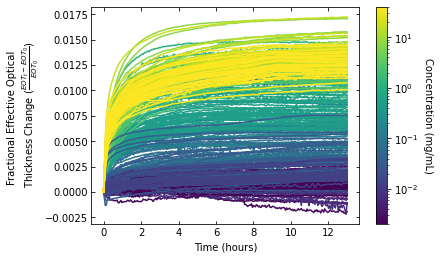

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import matplotlib
import math
from matplotlib import rc

df = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)

time = df.iloc[0,1:]/3600
dftrain = df.iloc[1:,:]

fig, ax = plt.subplots()

for row in dftrain.iterrows():
    colour = round(255*(math.log(float(row[1][0])+1e-2) - math.log(1e-2))/(math.log(40) - math.log(1e-2)))
    plt.plot(time,row[1][1:],c=pylab.cm.viridis(colour))
    
plt.xlabel("Time (hours)")
ax.set_ylabel('Fractional Effective Optical \n Thickness Change ' + r'($\frac{EOT_t - EOT_0}{EOT_0}$)')

sm = plt.cm.ScalarMappable(cmap=pylab.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=0.002, vmax=40))
colorbar = plt.colorbar(sm)
colorbar.ax.get_yaxis().labelpad = 15
colorbar.ax.set_ylabel("Concentration (mg/mL)", rotation=270)
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
plt.savefig(".."+"/Figures/ExperimentalTrainingDataset.tif", dpi=200, bbox_inches='tight')
plt.show()

## Experimental and least squares fit FEM simulated responses

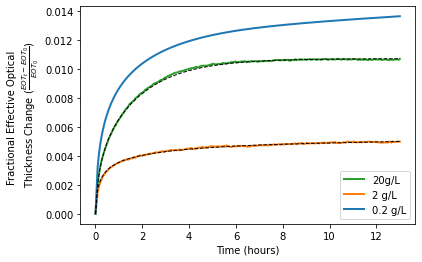

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile
from sklearn.preprocessing import StandardScaler
from matplotlib import rc

#import matplotlib
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# rc('text', usetex=True)
# rc('font', family='serif', serif=['Computer Modern Roman'],size=22)
# plt.rcParams['text.latex.preamble'] = [r'\boldmath \usepackage{bm}']

# files = [r"../TrainingData/20g_L.txt", #5
#          r"../TrainingData/2g_L.txt", #16
#          r"../TrainingData/2e_1g_L.txt", #22
#          r"../TrainingData/2e_2g_L.txt", #
#          r"../TrainingData/2e_3g_L.txt", #
#          r"../TrainingData/FEM20g_L.txt"] #5

files = ["../TrainingData/FEMExperimentalFitExamples/2g_L.txt", #16
         r"../TrainingData/FEMExperimentalFitExamples/2e_1g_L.txt", #22
#          r"../TrainingData/2e_2g_L.txt", #
#          r"../TrainingData/2e_3g_L.txt", #
         r"../TrainingData/FEMExperimentalFitExamples/FEM20g_L.txt"] #5

fig = plt.figure()
ax = fig.add_subplot(111)



colours = ['tab:green','tab:orange','tab:blue','tab:red','k']
labels = ['20g/L','2 g/L','0.2 g/L','0.02 g/L','0.002 g/L','FEM Model']
linestyles = ['solid','solid','solid','solid','dashed']
linewidths = [2,2,2,2,1]


i=0
for FileName, colour, label, linestyle, linewidth in zip(files, colours,labels,linestyles,linewidths):
    data=np.loadtxt(FileName)
    ax.plot(data[:,0]/3600, data[:,1], c=colour, linewidth=linewidth, label=label, linestyle=linestyle)

ax.legend()#fontsize = 18)

files = [r"../TrainingData/FEMExperimentalFitExamples/FEM2g_L.txt", #16
         r"../TrainingData/FEMExperimentalFitExamples/FEM2e_1g_L.txt"]#, #22
#          r"../TrainingData/FEM2e_2g_L.txt", #
#          r"../TrainingData/FEM2e_3g_L.txt"] #

for FileName, colour, label, linestyle in zip(files, colours,labels,linestyles):
    data=np.loadtxt(FileName)
    ax.plot(data[:,0]/3600, data[:,1], c='k', linewidth=1, linestyle='--')

ax.set_ylabel('Fractional Effective Optical \n Thickness Change ' + r'($\frac{EOT_t - EOT_0}{EOT_0}$)')#, fontsize = 18)

#ax.set_ylabel('Reflectance (a.u.)\n', fontsize = 'large')
ax.set_xlabel('Time (hours)')#, fontsize = 28)
#plt.tick_params(axis='y', left = False, labelleft = False)

#ax.set_xlim([420,900])
#ax.set_ylim([0,50])

# ax.text(445, 10, '(d)', fontsize = 'large')


# ax.text(765, 6.8, r'$55$ $mA \cdot cm^{-2}$', fontsize = 24, color = 'k')
# ax.text(765, 2.4, r'$40$ $mA \cdot cm^{-2}$', fontsize = 24, color = 'k')
# ax.text(765, -2, r'$25$ $mA \cdot cm^{-2}$', fontsize = 24, color = 'k')


# fig.set_figwidth(6*1.5)
# fig.set_figheight(4.8*1.5)

plt.savefig(".."+"/Figures/FEMExperimentalfitExamples.tif", dpi=200, bbox_inches='tight')
plt.show()

## Plot of representative examples for each concentration in training dataset

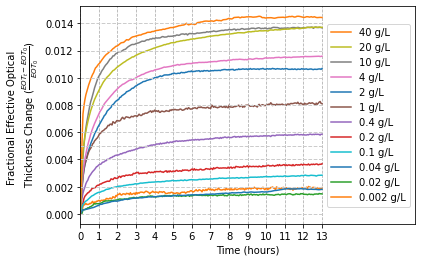

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import matplotlib
import math
from matplotlib import rc
import numpy as np

SequenceLength = 250

df = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)

time = df.iloc[0,:]/3600
dftrain = df.iloc[1:,:]

concentrations =  ["2",    "0.002",    "0.02",    "0.2",    "0.4",    "1",    "4",    "10",    "20",    "0.1",    "0.04",    "40"]
ExperimentNumber = [15,     13,         14,        3,        17,       10,     8,      22,      2,       4,        2,         2]
Labels =          ["2 g/L","0.002 g/L","0.02 g/L","0.2 g/L","0.4 g/L","1 g/L","4 g/L","10 g/L","20 g/L","0.1 g/L","0.04 g/L","40 g/L"]

fig, ax = plt.subplots()
Means = []
Stdevs = []
for concentration,experimentnumber,label in zip(concentrations,ExperimentNumber,Labels):
    dfConcentration = dftrain.loc[concentration,:]
    plt.plot(time,dfConcentration.iloc[experimentnumber,:],label=label)
    

handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [11,8,7,6,0,5,4,3,9,10,2,1]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="right")
plt.xlim(0,18) 
plt.xticks(range(14))
plt.xlabel("Time (hours)")
plt.grid(which='major',linestyle='--',axis='x')
[plt.hlines(y = i, xmin=0 , xmax = 13, color='0.8',linestyle='--',linewidth = 1) for i in np.linspace(0,0.014,8)]

ax.set_ylabel('Fractional Effective Optical \n Thickness Change ' + r'($\frac{EOT_t - EOT_0}{EOT_0}$)')


plt.savefig("../Figures/RepresentativeExperimentalTrainingDataset.tif", dpi=200, bbox_inches='tight')
plt.show()